

Project: Image classification of plants
Alfredo Coviello



In [1]:
import pandas as pd
import numpy as np
import math
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow
%matplotlib inline


In [3]:
from google.colab import auth, drive
#auth.authenticate_user()
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
trainLabel = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Labels.csv")

In [5]:
trainLabel

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [6]:
trainLabel.shape

(4750, 1)

In [7]:
images_np = np.load("/content/drive/My Drive/Colab Notebooks/images.npy")

In [8]:
images_np.dtype


dtype('uint8')

In [9]:
images_np.shape  

# 4750 images 128x128, rgb, i.e. 3 bytes per color

(4750, 128, 128, 3)

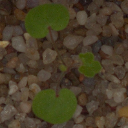

357 Small-flowered Cranesbill



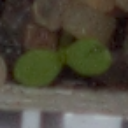

2742 Scentless Mayweed



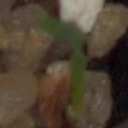

3910 Black-grass



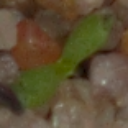

3122 Scentless Mayweed



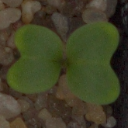

2375 Charlock



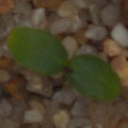

2617 Cleavers



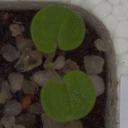

316 Small-flowered Cranesbill



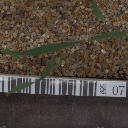

1308 Common wheat



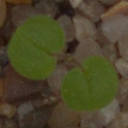

477 Small-flowered Cranesbill



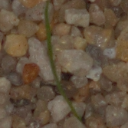

4303 Loose Silky-bent



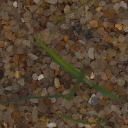

3957 Black-grass



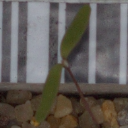

786 Fat Hen



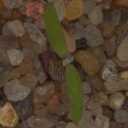

666 Fat Hen



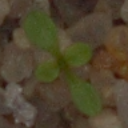

1026 Shepherds Purse



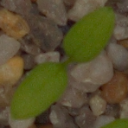

1646 Common Chickweed



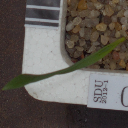

1293 Common wheat



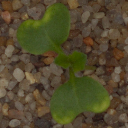

2059 Charlock



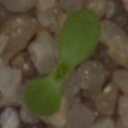

3119 Scentless Mayweed



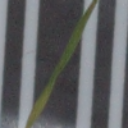

3948 Black-grass



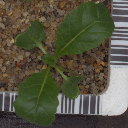

2054 Charlock



In [11]:
# Draw some images from the list
from google.colab.patches import cv2_imshow
import random as rnd
for i in range(0,20):
  index = math.floor(rnd.random()*4750)
  cv2_imshow(images_np[index])
  print(index, trainLabel.iloc[index]['Label'] + "\n")

In [12]:
trainLabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [13]:
trainLabel.describe()

,Label
count,4750
unique,12
top,Loose Silky-bent
freq,654


In [14]:
trainLabel.Label.unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [15]:
trainLabel.Label.unique().size
# 12 classes

12

In [16]:
# Pre-processing
images_gblur = images_np.copy()

In [17]:
images_gblur.shape

(4750, 128, 128, 3)

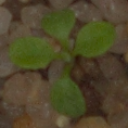

In [18]:
image1 = images_np[1048]
cv2_imshow(image1) # 1048 361

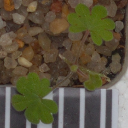

In [19]:
image2 = images_np[361]
cv2_imshow(image2) # 1048 361

Original Image:



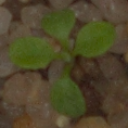


 Output after 5x5 gaussian blurring: 



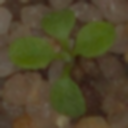


 Output after 11x11 gaussian blurring: 



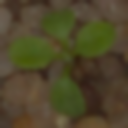


 Output after 15x15 gaussian blurring: 



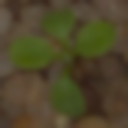

In [20]:
Gaussian1 = cv2.GaussianBlur(image1, (5, 5), 0)
Gaussian2 = cv2.GaussianBlur(image1, (11, 11), 0)
Gaussian3 = cv2.GaussianBlur(image1, (15, 15), 0)
print('Original Image:\n')
cv2_imshow(image1)
print('\n Output after 5x5 gaussian blurring: \n')
cv2_imshow(Gaussian1)
print('\n Output after 11x11 gaussian blurring: \n')
cv2_imshow(Gaussian2)
print('\n Output after 15x15 gaussian blurring: \n')
cv2_imshow(Gaussian3)

Original Image:



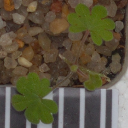


 Output after 5x5 gaussian blurring: 



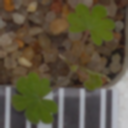


 Output after 11x11 gaussian blurring: 



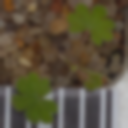


 Output after 15x15 gaussian blurring: 



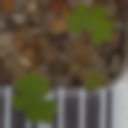

In [21]:
Gaussian1 = cv2.GaussianBlur(image2, (5, 5), 0)
Gaussian2 = cv2.GaussianBlur(image2, (11, 11), 0)
Gaussian3 = cv2.GaussianBlur(image2, (15, 15), 0)
print('Original Image:\n')
cv2_imshow(image2)
print('\n Output after 5x5 gaussian blurring: \n')
cv2_imshow(Gaussian1)
print('\n Output after 11x11 gaussian blurring: \n')
cv2_imshow(Gaussian2)
print('\n Output after 15x15 gaussian blurring: \n')
cv2_imshow(Gaussian3)

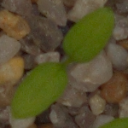

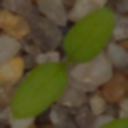

1791 Common Chickweed



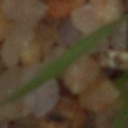

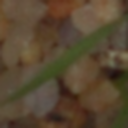

4292 Loose Silky-bent



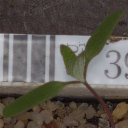

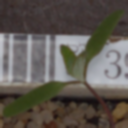

689 Fat Hen



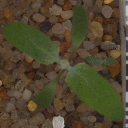

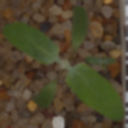

513 Fat Hen



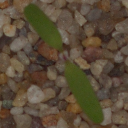

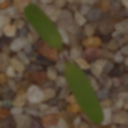

825 Fat Hen



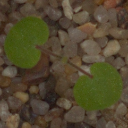

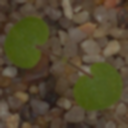

23 Small-flowered Cranesbill



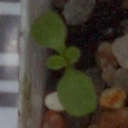

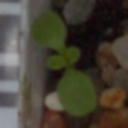

1067 Shepherds Purse



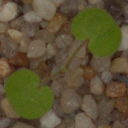

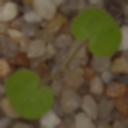

354 Small-flowered Cranesbill



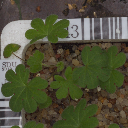

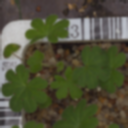

3 Small-flowered Cranesbill



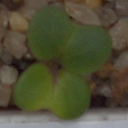

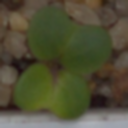

2264 Charlock



In [22]:
# I will use the 5x5 kernel and then the 15x15 to see the different performances

for index in range(0, images_np.shape[0]):
  images_gblur[index] = cv2.GaussianBlur(images_np[index], (5, 5), 0)

for i in range(0,10):
  index = math.floor(rnd.random()*4750)
  cv2_imshow(images_np[index])
  cv2_imshow(images_gblur[index])
  print(index, trainLabel.iloc[index]['Label'] + "\n")

# Original vs Blurred images:

In [23]:
# Normalization
images_gblur = images_gblur.astype('float32')
images_gblur /= 255


In [24]:
# Train/test split

from sklearn.model_selection import train_test_split 

# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12
epochs = 50
num_predictions = 20

X_train, X_test, y_train, y_test = train_test_split(images_gblur, trainLabel, test_size=0.3, random_state=8)

print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"y_test shape:{y_test.shape}")


X_train shape:(3325, 128, 128, 3)
X_test shape:(1425, 128, 128, 3)
y_train shape:(3325, 1)
y_test shape:(1425, 1)


In [25]:
# One hot encoding

dict_classes = { 'Small-flowered Cranesbill':0, 'Fat Hen':1, 'Shepherds Purse':2,
       'Common wheat':3, 'Common Chickweed':4, 'Charlock':5, 'Cleavers':6,
       'Scentless Mayweed':7, 'Sugar beet':8, 'Maize':9, 'Black-grass':10,
       'Loose Silky-bent':11}

y_train_int = y_train.copy()
y_test_int = y_test.copy()
y_train_int["Label"] = y_train.Label.map(lambda x: dict_classes[x])
y_test_int["Label"] = y_test.Label.map(lambda x: dict_classes[x])
y_train_oh = to_categorical(y_train_int, num_classes=num_classes)
y_test_oh = to_categorical(y_test_int, num_classes=num_classes)

print(f"y_train_oh shape:{y_train_oh.shape}")
print(f"y_test_oh shape:{y_test_oh.shape}")



y_train_oh shape:(3325, 12)
y_test_oh shape:(1425, 12)


In [70]:
y_train_oh[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [71]:
dict_classes

{'Black-grass': 10,
 'Charlock': 5,
 'Cleavers': 6,
 'Common Chickweed': 4,
 'Common wheat': 3,
 'Fat Hen': 1,
 'Loose Silky-bent': 11,
 'Maize': 9,
 'Scentless Mayweed': 7,
 'Shepherds Purse': 2,
 'Small-flowered Cranesbill': 0,
 'Sugar beet': 8}

In [73]:
y_train[0:1]

,Label
3372,Sugar beet


In [27]:
y_test_oh

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
type(y_train_oh)

numpy.ndarray

In [29]:
type(y_test_int)


pandas.core.frame.DataFrame

In [30]:
# Label for y_train[0]
y_train[0:1]['Label']

3372    Sugar beet
Name: Label, dtype: object

In [31]:
y_train[0:1]

,Label
3372,Sugar beet


In [32]:
X_train.shape[1:]

(128, 128, 3)

In [33]:
# CNN

model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [34]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 128)     147584    
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 256)       2

In [36]:
X_train

array([[[[0.19215687, 0.25490198, 0.30980393],
         [0.19607843, 0.25490198, 0.30588236],
         [0.19607843, 0.25490198, 0.30588236],
         ...,
         [0.14509805, 0.21960784, 0.28627452],
         [0.13333334, 0.20784314, 0.27058825],
         [0.13725491, 0.20392157, 0.27058825]],

        [[0.1882353 , 0.2509804 , 0.30588236],
         [0.19215687, 0.2509804 , 0.3019608 ],
         [0.19607843, 0.2509804 , 0.3019608 ],
         ...,
         [0.15686275, 0.23137255, 0.29803923],
         [0.14509805, 0.21568628, 0.28235295],
         [0.14901961, 0.21568628, 0.2784314 ]],

        [[0.18039216, 0.24313726, 0.29411766],
         [0.18431373, 0.24313726, 0.29411766],
         [0.19215687, 0.24705882, 0.29411766],
         ...,
         [0.18039216, 0.25882354, 0.32941177],
         [0.17254902, 0.23921569, 0.30588236],
         [0.17254902, 0.23529412, 0.29803923]],

        ...,

        [[0.16862746, 0.16470589, 0.17254902],
         [0.2       , 0.19607843, 0.2       ]

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)


In [38]:
X_train.shape

(3325, 128, 128, 3)

In [39]:
X_test.shape

(1425, 128, 128, 3)

In [40]:
y_train_oh.shape

(3325, 12)

In [ ]:
y_test_oh.shape

(1425, 12)

In [41]:
# 1st attempt 
# Training on the images blurred with a 15x15 kernel, and validation_split=0.2
# The training finished early at epoch 31, and accuracy of 98. 

model.fit(X_train, y_train_oh,
          #batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          validation_data=(X_test, y_test_oh),
          shuffle=True,
          verbose=1,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 2.3400 - accuracy: 0.2068
Epoch 00001: val_loss improved from inf to 1.89080, saving model to cifar_cnn_checkpoint_01_loss1.8908.h5
84/84 [==============================] - 18s 213ms/step - loss: 2.3400 - accuracy: 0.2068 - val_loss: 1.8908 - val_accuracy: 0.3714
Epoch 2/50
83/84 [============================>.] - ETA: 0s - loss: 1.7545 - accuracy: 0.4010
Epoch 00002: val_loss improved from 1.89080 to 1.58277, saving model to cifar_cnn_checkpoint_02_loss1.5828.h5
84/84 [==============================] - 17s 197ms/step - loss: 1.7549 - accuracy: 0.4008 - val_loss: 1.5828 - val_accuracy: 0.5008
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 1.4605 - accuracy: 0.4944
Epoch 00003: val_loss improved from 1.58277 to 1.31975, saving model to cifar_cnn_checkpoint_03_loss1.3198.h5
84/84 [==============================] - 17s 198ms/step - loss: 1.4605 - accuracy: 0.4944 - val_loss: 1.3198 - val_accuracy: 0.5

In [ ]:
# 2nd attempt
# Attempted a training on images blurred with a 15x15 kernel, and validation_split=0.2, but with half of neurons in all layers.
# The training finished early at epoch 29 with an accuracy of 0.97

# 3rd attempt
# Training on images blurred with a 15x15 kernel, with validation_split=0.5
# The training finished early at epoch 33 with an accuracy of 0.95


In [42]:
# Score trained model, 15x15 blur, .2 validation_split

scores = model.evaluate(X_test, y_test_oh, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 3s 57ms/step - loss: 1.5180 - accuracy: 0.7277
Test loss: 1.5179812908172607
Test accuracy: 0.7277193069458008


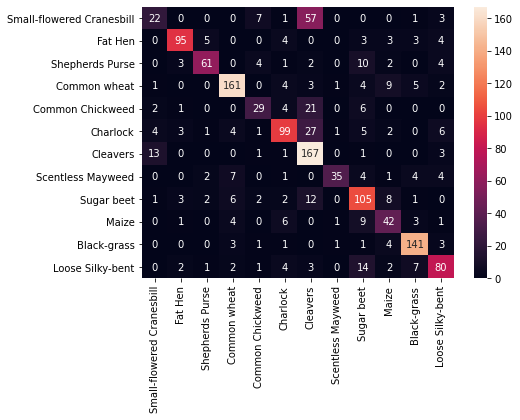

In [99]:
# Confusion Matrix
import sklearn.metrics
import seaborn as sns
classes = []
for k in dict_classes.keys():
  i = dict_classes[k]
  classes.insert(i, k)

y_predict = model.predict(X_test)

y_predict_label = []

i=0
for row in y_predict:
  #print(row)
  y_predict_label.insert(i, classes[np.argmax(row)])
  i += 1

cm= sklearn.metrics.confusion_matrix(y_test, y_predict_label)

df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')


In [97]:
cm

array([[ 22,   0,   0,   0,   7,   1,  57,   0,   0,   0,   1,   3],
       [  0,  95,   5,   0,   0,   4,   0,   0,   3,   3,   3,   4],
       [  0,   3,  61,   0,   4,   1,   2,   0,  10,   2,   0,   4],
       [  1,   0,   0, 161,   0,   4,   3,   1,   4,   9,   5,   2],
       [  2,   1,   0,   0,  29,   4,  21,   0,   6,   0,   0,   0],
       [  4,   3,   1,   4,   1,  99,  27,   1,   5,   2,   0,   6],
       [ 13,   0,   0,   0,   1,   1, 167,   0,   1,   0,   0,   3],
       [  0,   0,   2,   7,   0,   1,   0,  35,   4,   1,   4,   4],
       [  1,   3,   2,   6,   2,   2,  12,   0, 105,   8,   1,   0],
       [  0,   1,   0,   4,   0,   6,   0,   1,   9,  42,   3,   1],
       [  0,   0,   0,   3,   1,   1,   0,   1,   1,   4, 141,   3],
       [  0,   2,   1,   2,   1,   4,   3,   0,  14,   2,   7,  80]])

In [100]:
y_test.shape

(1425, 1)

In [126]:
# Predictions for 2, 3, 33, 36, 59

predictions = [2, 3, 33, 36, 59]

for p in predictions:
  print(f"Prediction for {p}: { y_predict_label[p:p+1] } actual: { y_test.iloc[p]['Label'] }")

Prediction for 2: ['Common wheat'] actual: Common wheat
Prediction for 3: ['Maize'] actual: Maize
Prediction for 33: ['Fat Hen'] actual: Fat Hen
Prediction for 36: ['Common Chickweed'] actual: Common Chickweed
Prediction for 59: ['Sugar beet'] actual: Fat Hen
